# Sensitivity Analysis and Data Assimilation on the example of Lorenz and SEIR models

Today's tutorial will be divided into three parts:

1. Introduction to Lorenz and SEIR models
1. Sensitivity analysis
1. Data assimilation with 4DVar

# Introduction to Lorenz and SEIR models



### Lorenz

![Lorenz equations](images/lorenz.png)

source: https://en.wikipedia.org/wiki/Lorenz_system

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

Method that computes one timestep of Lorenz model:

In [2]:
def lorenz_step(state, _, rho, sigma, beta):
    x, y, z = state  # Unpack the state vector
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

Let's draw the model's trajectory for the basic parameters:

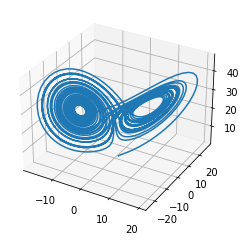

In [143]:
rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0

state0 = [1,1,1]

t = np.arange(0.0, 40.0, 0.01)

states = odeint(lorenz_step, state0, t, args=(rho,sigma,beta))

fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot(states[:, 0], states[:, 1], states[:, 2])
plt.draw()
plt.show()

### SEIR

![SEIR epidemic model](images/seir.png)

SEIR is a model that simulates an outbreak of a virus.

The population is divided into four groups:
* S - group of humans **susceptible** to be exposed to the virus. Before an epidemic starts, all population members belong to this group.
* E - group of people that were **exposed** to the virus. In this stage they already started to develop the illness, but they don't show symptoms nor infect others yet.
* I - group of **infectious** individuals, who can pass the virus to susceptible members.
* R - people that have already **recovered** from the infection.

Additionaly we can specify two more groups:
* D - a group of individuals that are **dead** as a result of the infection
* N - total number of alive individuals

---

There are four parameters. The reasonable bounds for them are given in the brackets:
* alfa - the case fatality rate - fraction of Infected group that dies each day. [0.001, 0.01]
* beta - probability of disease transmission times the number of contacts per day. [0, 7]
* epsilon - rate of progression from Exposed to Infectious (so 1/eps is the incubation period). [0.05, 0.5] (from 2 to 20 days)
* gamma - rate of progression from Infectious to Recovered (so 1/gamma is the length of the infectious period) [0.05, 0.5] (from 2 to 20 days)


---

These are the equations which represent the group size in the following time step:

S = S - S \* beta \* I / N  
E = E + S \* beta \* I / N - eps \* E  
I = I + eps \* E - (alfa + gamma) \* I  
R = R + gamma \* I  
D = alfa \* I  


In [4]:
def seir_step(state):
    state = list(np.ravel(state))
    state = list(map(lambda x : max(x, 0), state))
    S_old, E_old, I_old, R_old, D_old, alfa, beta, eps, gamma = state

    N = S_old + E_old + I_old + R_old
    D = D_old + alfa * I_old
    S = S_old - S_old * beta * I_old / N
    E = E_old + S_old * beta * I_old / N - eps * E_old
    I = I_old + eps * E_old - (alfa + gamma) * I_old
    R = R_old + gamma * I_old

    results = [S, E, I, R, D, alfa, beta, eps, gamma]
    return np.array(results).reshape(-1, 1)

Let's simulate a sample epidemic

**TASK 1** Choose some values from the reasonable bounds introduced earlier and observe the effect on the plots



Susceptible, exposed, infectious, recovered and dead individuals


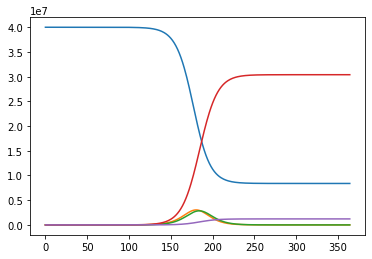

In [52]:
# TODO: insert values for alfa, beta, eps, gamma
params = [ ??? ]
seird = [40000000, 1, 0, 0, 0]
state = np.array(seird + params).reshape(-1, 1)

days = 365

states = np.empty((days,5))
for i in range(days):
    states[i]  = state[:5][:,0]
    state = seir_step(state)

plt.plot( range(days),states[:,0])
plt.plot( range(days),states[:,1])
plt.plot( range(days),states[:,2])
plt.plot( range(days),states[:,3])
plt.plot( range(days),states[:,4])
print('Susceptible, exposed, infectious, recovered and dead individuals')

Exposed, infectious and dead individuals


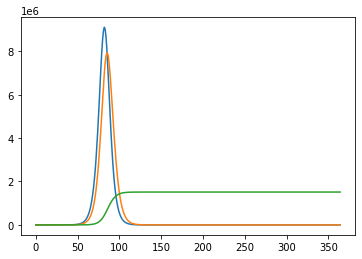

In [51]:
plt.plot( range(days),states[:,1])
plt.plot( range(days),states[:,2])
plt.plot( range(days),states[:,4])
print('Exposed, infectious and dead individuals')

# Sensitivity analysis

In order to check which parameters of the model have the biggest influence on the output, we can perform a Sensitivity Analysis. SALib is a Python library that implements it. It does two things:


1.   Generates a set of inputs to be fed to the model
2.   Analyses outputs returned by the model for this set of inputs


In [28]:
from SALib.sample import saltelli
from SALib.analyze import sobol

### Sensitivity analysis - Lorenz 63 model

We will perform SA on Lorenz 63 model. First, we need to define the parameters of the model and generate a set of input parameters.

In [46]:
problem = {
    'num_vars': 3,
    'names': ['rho', 'sigma', 'beta'],
    'bounds': [[14.0,42.0],
               [3.0, 20.0],
               [7.0/3.0, 9.0/3.0]]
}

#Let's generate 20 values for each parameter:
input = saltelli.sample(problem, 20)

print(input.shape)
print(input[:5])

(160, 3)
[[20.15234375  4.64355469  2.67903646]
 [32.94921875  4.64355469  2.67903646]
 [20.15234375  7.76464844  2.67903646]
 [20.15234375  4.64355469  2.93815104]
 [20.15234375  7.76464844  2.93815104]]


Now, we need to define our model and generate an output value for each input (each set of parameters)

Lorenz model has a 3-dimensional state (x,y,z) for each timestep. However, SA can only analyse a single output for a given input.

In order to deal with that, we will analyse the sensitivity in the 3 dimensions separately. We will analyse the standard deviation of values in each dimension.

In [40]:
def generate_outputs_lorenz(parameter_combinations):
    # We need an output array with a row for each generated input and 3 colums for 3 output variables (x, y, z)
    output = np.empty( shape=(parameter_combinations.shape[0],3) )
    # Define timesteps for Lorenz 63 integration
    t = np.arange(0.0, 40.0, 0.01)

    for i, params in enumerate(parameter_combinations):
        initial_state = [1,1,1]
        rho, sigma, beta = params[0], params[1], params[2]

        # Get states in each timestep:
        states = odeint(lorenz_step, initial_state, t, args=(rho, sigma, beta))

        # We take the standard deviation in each dimension as the output.
        output[i] = np.std(states, axis=0)
    return output

output = generate_outputs_lorenz(input)

Finally, we can analyse the sensitivity. We analyse it in respect to each output dimension separately

In [41]:
Si_X = sobol.analyze(problem, output[:,0], print_to_console=False)['S1']
Si_Y = sobol.analyze(problem, output[:,1], print_to_console=False)['S1']
Si_Z = sobol.analyze(problem, output[:,2], print_to_console=False)['S1']

print('           ', list(map(lambda name: name + ' '*(5-len(name)),    problem['names'])))
print('X analysis:', list(map(lambda number: '{0:.3f}'.format(number),  Si_X)))
print('Y analysis:', list(map(lambda number: '{0:.3f}'.format(number),  Si_Y)))
print('Z analysis:', list(map(lambda number: '{0:.3f}'.format(number),  Si_Z)))

            ['rho  ', 'sigma', 'beta ']
X analysis: ['1.046', '0.181', '0.105']
Y analysis: ['0.991', '0.166', '0.059']
Z analysis: ['0.969', '0.065', '0.045']


The higher the value, the more the parameter affects the behaviour of the model.
The rho parameter influences all dimensions of model significantly.

### Sensitivity analysis - SEIR model

Now we will perform a similar SA on the SEIR model

**TASK 2** Just like in the Lorenz example, define the number of variables, their names and the bounds. Use the bounds provided in the definition of the model

In [47]:
problem_seir = {
    'num_vars': ??? ,
    'names': ??? ,
    'bounds': ???
}

input = saltelli.sample(problem_seir, 100)

print(input.shape)
print(input[:5])

(1000, 4)
[[2.97753906e-03 6.76757812e-01 2.83349609e-01 3.54541016e-01]
 [3.52246094e-03 6.76757812e-01 2.83349609e-01 3.54541016e-01]
 [2.97753906e-03 6.35058594e+00 2.83349609e-01 3.54541016e-01]
 [2.97753906e-03 6.76757812e-01 7.06542969e-02 3.54541016e-01]
 [2.97753906e-03 6.76757812e-01 2.83349609e-01 4.54736328e-01]]


Again we encounter the same problem: SA can analyse only one 1-dimensional output for a given input, while SEIR is a time series with 5 groups (5 dimensions). We will deal with that in two ways separately:
* analyse the final amount of dead individuals
* analyse the maximum amount of infected individuals at a single moment

In [14]:
def generate_outputs_seir(parameter_combinations):
    # We need an output array with a row for each generated input
    output_final = np.empty( shape=(parameter_combinations.shape[0]) )
    output_max = np.empty( shape=(parameter_combinations.shape[0]) )

    for i, params in enumerate(parameter_combinations):
        initial_state = np.array([39900000, 60000, 10000, 80000, 2300])
        state = np.concatenate((initial_state, params))

        max_infected = 0
        for step in range(200):
            state = seir_step(state)
            if state[:][2] > max_infected:
                max_infected = state[:][2]
        output_final[i] = state[:][4]
        output_max[i] = max_infected
    return output_final, output_max

output_final, output_max = generate_outputs_seir(input)

In [20]:
print('                      ', list(map(lambda name: name + ' '*(5-len(name)),    problem_seir['names'])))
Si = sobol.analyze(problem_seir, output_final, print_to_console=False)['S1']
print('Final deaths analysis:', list(map(lambda number: '{0:.3f}'.format(number),  Si)))
Si = sobol.analyze(problem_seir, output_max, print_to_console=False)['S1']
print('Max infected analysis:', list(map(lambda number: '{0:.3f}'.format(number),  Si)))

                       ['alfa ', 'beta ', 'eps  ', 'gamma']
Final deaths analysis: ['0.219', '-0.002', '-0.004', '0.654']
Max infected analysis: ['0.001', '0.197', '0.334', '0.534']


# Data assimilation with 4DVar

This algorithm realizes an estimation of the state of a dynamic system, by a variational minimization method of the classical J function in data assimilation:
![4dvar function](images/4dvar.png)

For calculations we used ADAO python library - [documentation](https://docs.salome-platform.org/latest/gui/ADAO/en/ref_algorithm_4DVAR.html)

### 4d var with Lorenz 63 model

In [145]:
from data_assimilation import assimilate

In [146]:
def prepare_obs(state, obs_operator, evolution_function, size=100):
    obs = []
    for i in range(size):
        obs.append(obs_operator(state))
        state = evolution_function(state)
    return obs


In [147]:
rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0

d = 0.01
xb = [1., 1., 1.] + [rho, sigma, beta]
xb = np.array(xb).reshape(-1, 1)

In [148]:
def lorenz_obs_operator(state):
    return state[:3]

In [149]:
def lorenz_evol_step(state):
    list(np.ravel(state))
    x, y, z, rho, sigma, beta = state  # Unpack the state vector
    rho, sigma, beta = list(map(lambda x : max(x, 0), [rho, sigma, beta]))
    dx, dy, dz = lorenz_step([x, y, z], "", rho, sigma, beta)
    return np.array([x + d * dx, y + d * dy, z + d * dz, rho, sigma, beta]).reshape(-1, 1)

In [150]:
yobs = np.array(prepare_obs(xb, lorenz_obs_operator, lorenz_evol_step, 200))

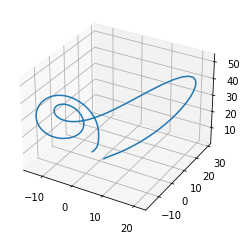

In [151]:
states = yobs
fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot(states[:, 0].flatten(), states[:, 1].flatten(), states[:, 2].flatten())
plt.draw()
plt.show()

In [153]:
xb = [1., 1., 1.] + [10., 10., 10.]
xb = np.array(xb).reshape(-1, 1)

result = assimilate(xb, yobs, lorenz_obs_operator, lorenz_evol_step, verbose=True)

  Intermediate CurrentState at the current iteration: [ 1.  1.  1. 10. 10. 10.]
  Intermediate CurrentState at the current iteration: [ 1.47112697  1.77418401  0.94421845 10.10544413 10.0653452   9.59977699]
  Intermediate CurrentState at the current iteration: [ 3.35563487  4.87092003  0.72109223 10.52722063 10.326726    7.99888494]
  Intermediate CurrentState at the current iteration: [ 3.69315889  5.51065621  0.59733983 11.65794768 10.33471874  5.37778565]
  Intermediate CurrentState at the current iteration: [ 3.72120732  5.6782031   1.85097663 15.43799506  9.51116556 -5.83066202]


/home/qwerty/anaconda2/envs/p3/lib/python3.6/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


ValueError: during execution, the following error occurs:

failed to initialize intent(inout) array -- input 'O' not compatible to 'd' 

See also the potential messages, which can show the origin of the above error, in the launching terminal.


In [140]:
res = np.array(prepare_obs(np.array(result).reshape(-1, 1), lorenz_obs_operator, lorenz_evol_step, 200))

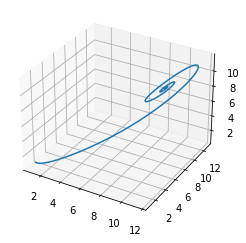

In [141]:
states = res
fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot(states[:, 0].flatten(), states[:, 1].flatten(), states[:, 2].flatten())
plt.draw()
plt.show()

### SEIR epidemic model

We will try to generate data based on SEIR model and then based on these observations we will use 4D-Var data assimilation to find parameters.

In our case observations is total number of deaths to given day.

In [1]:
# we need to define observation operator that transforms given state 
# (SEIRD + [alpha, beta, eps, gamma]) to the observations (total number of deaths to given day)
def seir_obs_operator(state):
    D = state.reshape((-1, 9))[:, 4]
    return D

In [2]:
# we define some random parameters, to generate observations
params = [0.006, 0.75, 0.125, 0.33]
seird = [100000, 100, 0, 0, 0]
state = np.array(seird + params).reshape(-1, 1)
days = 200

NameError: name 'np' is not defined

In [3]:
# generate observations based on prepared earlier parameters
yobs = prepare_obs(state, seir_obs_operator, seir_step, size=days)

NameError: name 'prepare_obs' is not defined

In [61]:
# now we try to find parameters that will result in matching observations
result = assimilate(seird + [0.01, 0.5, 0.5, 0.5], yobs, seir_obs_operator, seir_step, verbose=True)

  Intermediate CurrentState at the current iteration: [1.e+05 1.e+02 0.e+00 0.e+00 0.e+00 1.e-02 5.e-01 5.e-01 5.e-01]
  Intermediate CurrentState at the current iteration: [ 1.00000000e+05  1.00000106e+02  1.07178715e-04 -1.57166335e-06
  2.86663849e-04  9.01289100e-01  8.14625189e-01  5.06107745e-01
  1.73538178e-01]
  Intermediate CurrentState at the current iteration: [ 1.00000000e+05  1.00000693e+02  6.92150240e-04 -1.80349211e-06
  4.92075995e-04  8.72878216e-01  1.08507023e+00  5.05224760e-01
 -9.83192429e-02]
  Intermediate CurrentState at the current iteration: [ 1.00000000e+05  1.00000106e+02  1.07198410e-04 -1.57167115e-06
  2.86670764e-04  9.01288143e-01  8.14634294e-01  5.06107716e-01
  1.73529025e-01]
  Intermediate CurrentState at the current iteration: [ 1.00000000e+05  1.00000106e+02  1.07218105e-04 -1.57167896e-06
  2.86677680e-04  9.01287187e-01  8.14643400e-01  5.06107686e-01
  1.73519872e-01]
  Intermediate CurrentState at the current iteration: [ 1.00000000e+05  1

  Intermediate CurrentState at the current iteration: [ 1.00000000e+05  1.00000643e+02  3.50132110e-04 -2.42903367e-07
  1.37168294e-04  1.44635336e-01  5.73159247e-01  6.64691727e-01
  4.15388422e-01]
  Intermediate CurrentState at the current iteration: [ 1.00000000e+05  1.00000905e+02  6.11123301e-04 -2.14188518e-07
  1.69404613e-04  1.41156658e-01  5.64061572e-01  7.06802646e-01
  4.09752505e-01]
  Intermediate CurrentState at the current iteration: [ 1.00000000e+05  1.00002051e+02  1.74923679e-03 -3.46312079e-08
  2.99644715e-04  9.59982705e-02  5.11860785e-01  8.93381628e-01
  3.98421927e-01]
  Intermediate CurrentState at the current iteration: [ 1.00000000e+05  1.00001297e+02  1.00063012e-03 -1.52737004e-07
  2.13977855e-04  1.25701697e-01  5.46196427e-01  7.70657250e-01
  4.05874739e-01]
  Intermediate CurrentState at the current iteration: [ 1.00000000e+05  1.00002009e+02  1.71384157e-03 -4.54668160e-08
  2.95430362e-04  9.94955648e-02  5.15163175e-01  8.85398124e-01
  3.9790

  Intermediate CurrentState at the current iteration: [ 1.00000000e+05  1.00000232e+02  6.76678532e-04 -3.13491664e-07
 -5.86819696e-05  2.02827123e-02  6.50960300e-01  4.53008937e-01
  4.97126867e-01]
  Intermediate CurrentState at the current iteration: [ 1.00000000e+05  9.99996727e+01  3.50946268e-04 -3.22487768e-07
 -1.66978066e-04  1.83702536e-02  7.01581992e-01  3.17001131e-01
  5.18196634e-01]
  Intermediate CurrentState at the current iteration: [ 1.00000000e+05  1.00000120e+02  6.11741486e-04 -3.15285101e-07
 -8.02715675e-05  1.99014500e-02  6.61052095e-01  4.25894813e-01
  5.01327275e-01]
  Intermediate CurrentState at the current iteration: [ 1.00000000e+05  1.00000044e+02  6.23757536e-04 -2.97139363e-07
 -1.04405376e-04  1.88231939e-02  6.76173865e-01  3.96051655e-01
  5.05643275e-01]
  Intermediate CurrentState at the current iteration: [ 1.00000000e+05  1.00000035e+02  6.51449585e-04 -2.78935404e-07
 -1.11693206e-04  1.86905043e-02  6.81762414e-01  3.87471055e-01
  5.0654

In [62]:
# generate new observations based on result from data assimilation
res = prepare_obs(result, seir_obs_operator, seir_step, size=200)

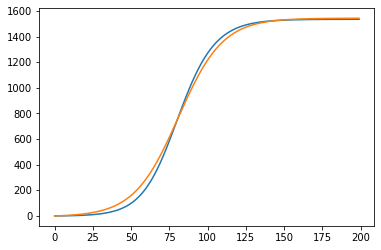

In [64]:
plt.plot(range(days), yobs)
plt.plot(range(days), res)

### Assimilation of actual data

Here we try to fir parameters to the actual data concerning COVID-19

In [43]:
from data_assimilation import load_data
yobs = load_data(size = 100, country = 'POL')

In [26]:
seird = [36000000, 30000, 10000, 80000, 2349]
result = assimilate(seird + [0.01, 0.1, 0.1, 0.1], yobs, seir_obs_operator, seir_step, verbose=True)

  Intermediate CurrentState at the current iteration: [3.600e+07 3.000e+04 1.000e+04 8.000e+04 2.349e+03 1.000e-02 1.000e-01
 1.000e-01 1.000e-01]
  Intermediate CurrentState at the current iteration: [ 3.60000000e+07  3.00000000e+04  1.00000000e+04  8.00000000e+04
  2.34900000e+03  9.44147952e-01  3.25434052e-01  1.49468364e-01
 -1.72213104e-01]
  Intermediate CurrentState at the current iteration: [3.60000000e+07 3.00000000e+04 1.00000000e+04 8.00000000e+04
 2.34900000e+03 1.75332409e-01 1.39898985e-01 1.08755277e-01
 5.18217130e-02]
  Intermediate CurrentState at the current iteration: [3.60000000e+07 3.00000000e+04 1.00000000e+04 8.00000000e+04
 2.34900000e+03 2.15084380e-02 1.02777284e-01 1.00609436e-01
 9.66464117e-02]
  Intermediate CurrentState at the current iteration: [3.60000000e+07 3.00000000e+04 1.00000000e+04 8.00000000e+04
 2.34900000e+03 1.41595073e-02 1.01003797e-01 1.00220269e-01
 9.87879089e-02]
  Intermediate CurrentState at the current iteration: [3.60000000e+07 3.

  Intermediate CurrentState at the current iteration: [3.60000000e+07 3.00000000e+04 1.00000000e+04 8.00000000e+04
 2.34899995e+03 3.90282757e-03 7.95320346e-02 1.19344897e-01
 4.31247846e-02]
  Intermediate CurrentState at the current iteration: [3.60000000e+07 3.00000000e+04 1.00000000e+04 8.00000000e+04
 2.34899990e+03 3.71897543e-03 3.74801328e-02 1.36898011e-01
 1.34926574e-02]
  Intermediate CurrentState at the current iteration: [3.60000000e+07 3.00000000e+04 1.00000000e+04 8.00000000e+04
 2.34899994e+03 3.86975739e-03 7.19679996e-02 1.22502242e-01
 3.77947416e-02]
  Intermediate CurrentState at the current iteration: [3.60000000e+07 3.00000000e+04 1.00000000e+04 8.00000000e+04
 2.34899994e+03 3.77752654e-03 6.94752645e-02 1.23707760e-01
 3.53715901e-02]
  Intermediate CurrentState at the current iteration: [3.60000000e+07 3.00000000e+04 1.00000000e+04 8.00000000e+04
 2.34899990e+03 3.04527349e-03 4.00678224e-02 1.37168671e-01
 1.10948251e-02]
  Intermediate CurrentState at the 

  Intermediate CurrentState at the current iteration: [ 3.60000000e+07  3.00000000e+04  1.00000000e+04  8.00000000e+04
  2.34899985e+03  2.69764117e-03  2.33681078e-04  1.52124650e-01
 -2.18516852e-02]
  Intermediate CurrentState at the current iteration: [3.60000000e+07 3.00000000e+04 1.00000000e+04 8.00000000e+04
 2.34899988e+03 3.06532331e-03 2.62215621e-02 1.42045911e-01
 2.24818327e-05]
  Intermediate CurrentState at the current iteration: [ 3.60000000e+07  3.00000000e+04  1.00000000e+04  8.00000000e+04
  2.34899986e+03  2.82265310e-03  9.06956064e-03  1.48697878e-01
 -1.44144684e-02]
  Intermediate CurrentState at the current iteration: [3.60000000e+07 3.00000000e+04 1.00000000e+04 8.00000000e+04
 2.34899988e+03 3.06528017e-03 2.62185126e-02 1.42047094e-01
 1.99150425e-05]
  Intermediate CurrentState at the current iteration: [ 3.60000000e+07  3.00000000e+04  1.00000000e+04  8.00000000e+04
  2.34899987e+03  2.90514630e-03  1.49002043e-02  1.46436612e-01
 -9.50677805e-03]
  Interm

In [ ]:
res = prepare_obs(result, seir_obs_operator, seir_step)

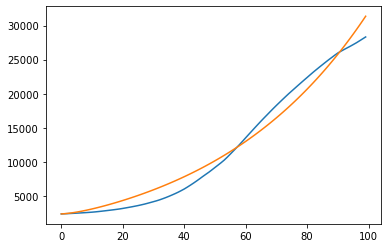

In [47]:
plt.plot(range(100), yobs)
plt.plot(range(100), res)